In [1]:
%matplotlib inline

# Advanced Registration for Aut1367
In this tutorial we align a CLARITY brain Control258 to the Allen Reference Atlas (ARA).  Thus the ARA is our _reference_ image, it consists of image data stored in the default "average" channel and corresponding annotations stored in a separate "annotation" channel.  We begin by importing the relevant modules

In [3]:
import os
os.chdir('/Users/albert/ndreg')

In [22]:
from ndreg import *
import matplotlib
import ndio.remote.neurodata as neurodata
import nibabel as nb

In [5]:
refToken = "ara_ccf2"
refImg = imgDownload(refToken)

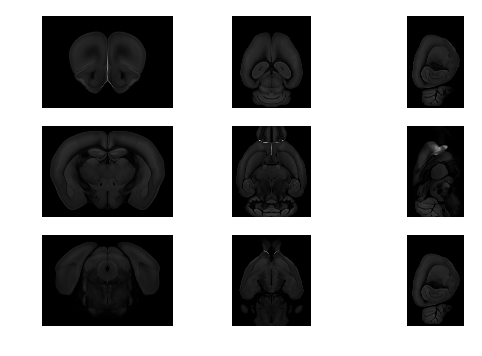

In [6]:
imgShow(refImg)

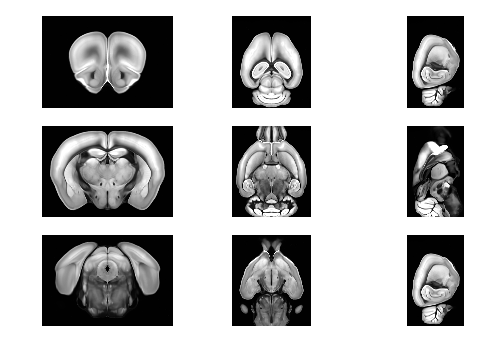

In [7]:
imgShow(refImg, vmax=500)

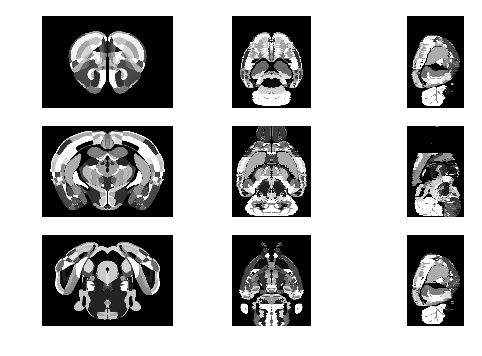

In [8]:
refAnnoImg = imgDownload(refToken, channel="annotation")
imgShow(refAnnoImg, vmax=1000)

In [9]:
randValues = np.random.rand(1000,3)

In [10]:
randValues = np.concatenate(([[0,0,0]],randValues))

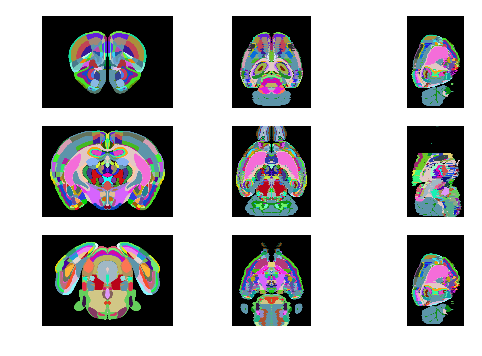

In [11]:
randCmap = matplotlib.colors.ListedColormap (randValues)
imgShow(refAnnoImg, vmax=1000, cmap=randCmap)

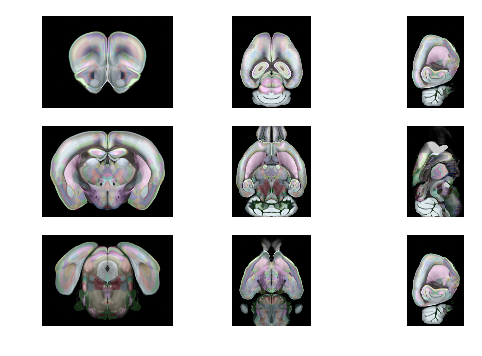

In [12]:
imgShow(refImg, vmax=500, newFig=False)
imgShow(refAnnoImg, vmax=1000, cmap=randCmap, alpha=0.2, newFig=False)
plt.show()

## Downloading Aut1367 brain

In [16]:
inToken = "152DLS_tail/"
nd = neurodata()
print(nd.get_metadata(inToken)['dataset']['voxelres'].keys())

[u'10', u'1', u'0', u'3', u'2', u'5', u'4', u'7', u'6', u'9', u'8']


Clearly resolution 5 is the lowest available resolution.  So we'll download the CLARITY image at that resolution.  Depending on your internet connection downloading may take several minutes.

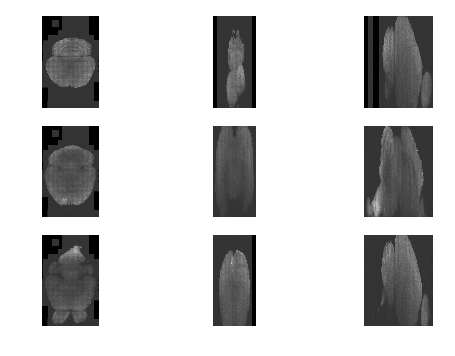

In [42]:
inImg = imgRead("../data/Aut1374.img")
#inImg(load_data)
imgShow(inImg, vmax=500)

In [44]:
inImg.SetSpacing([0.01872, 0.01872, 0.005]) # Setting manually due to bug https://github.com/neurodata/ndstore/issues/326

## Resampling CLARITY image
Notice how the CLARITY brain's resolution is higher than the ARA image that we want to align it to.

In [45]:
print(inImg.GetSpacing())

(0.01872, 0.01872, 0.005)


In [46]:
print(refImg.GetSpacing())

(0.024999999999999998, 0.024999999999999998, 0.024999999999999998)


Since we are aliging the CLARITY image to a lower resolution atlas, we can save memory by downsampling it to the resolution atlas.

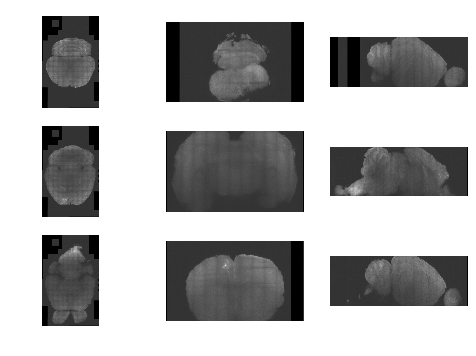

In [47]:
inImg = imgResample(inImg, spacing=refImg.GetSpacing())
imgShow(inImg, vmax=500)

## Reorienting CLARITY image
You may have noticed that the CLARITY brain is not oriented in the same way as the atlas.  Let's look at the atlas.

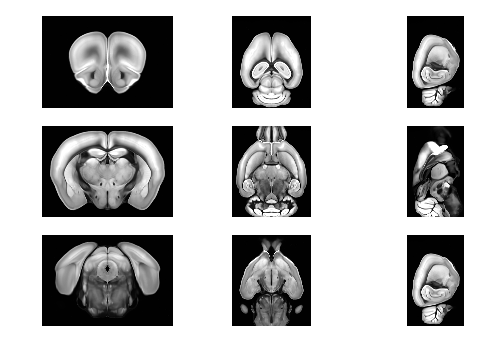

In [48]:
imgShow(refImg, vmax=500)

By examining the the z slices in the first column its clear that the x-axis goes from **R**ight to Left side of the brain. The y-axis varies from **S**uperior to Inferior and the z-axis goes from **A**nterior to posterior.  Thus it is in **RSA** orientation.  Looking at the the CLARITY brain...

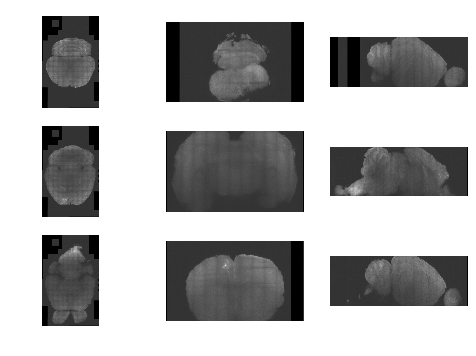

In [49]:
imgShow(inImg, vmax=500)

...we see that the x-axis goes from **L**eft to right, the y-axis goes from **A**nterior to Posterior and the Z axis goes from **I**nferior to Superior.  Thus it's in **LAI** orientation.  Therefore we reorient the CLARITY image from **LAI** to **RSA**

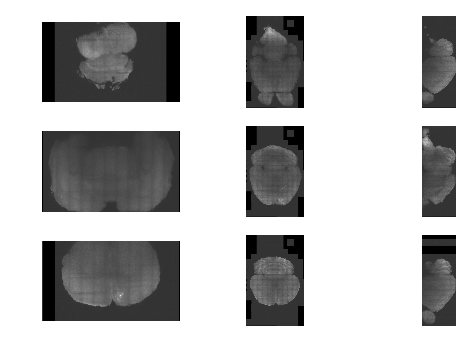

In [50]:
inImg = imgReorient(inImg, "LAI", "RSA")
imgShow(inImg, vmax=500)

Compare the above to the Atlas.  The slices should now correspond with the atlas.

## Thresholding CLARITY image
Lets plot the histogram of the CLARITY image

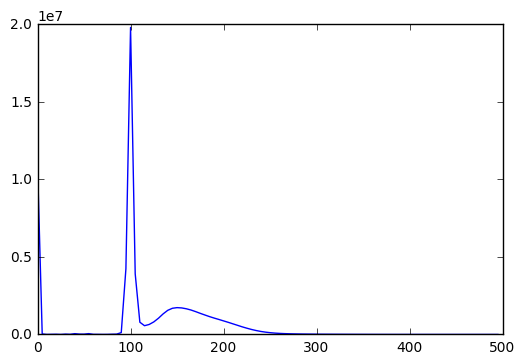

In [51]:
(values, bins) = np.histogram(sitk.GetArrayFromImage(inImg), bins=100, range=(0,500))
plt.plot(bins[:-1], values)

Notice the huge spike at 100.  This occurs because the intensity of the background is about 100. Idealy we want a black background with an intensity of 0.  Therefore we'll threhold the image below 100 and then subtract 100 from the image.

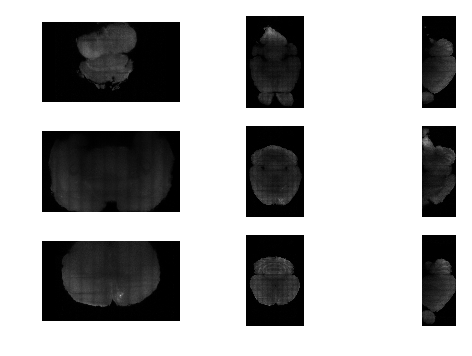

In [52]:
lowerThreshold = 100
upperThreshold = sitk.GetArrayFromImage(inImg).max()+1

inImg = sitk.Threshold(inImg,lowerThreshold,upperThreshold,lowerThreshold) - lowerThreshold
imgShow(inImg, vmax = 500)

Here's a histogram of the result

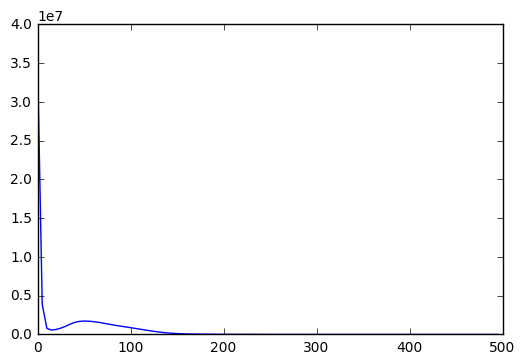

In [53]:
(values, bins) = np.histogram(sitk.GetArrayFromImage(inImg), bins=100, range=(0,500))
plt.plot(bins[:-1], values)

## Generating CLARITY mask
CLARITY brains contain really brignt fluorescent spots in the cerebral cortex and thalamus which can interfer with the registration.

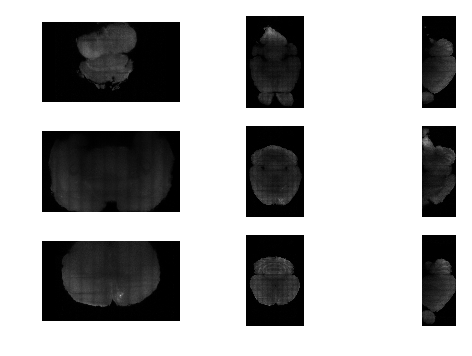

In [54]:
imgShow(inImg, vmax = 500)

## Affine Registration
Computer cannot handle even 0.25 so unfortunately spacing is 1.5

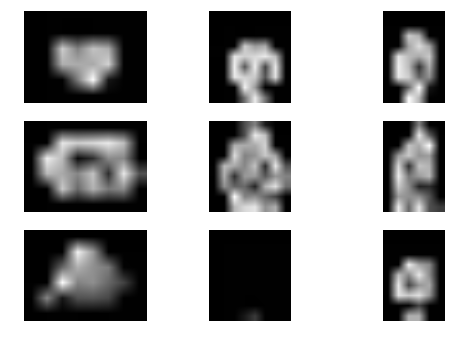

In [70]:
spacing=[1.5,1.5,1.5]
refImg_ds = imgResample(refImg, spacing=spacing)
imgShow(refImg_ds, vmax=500)

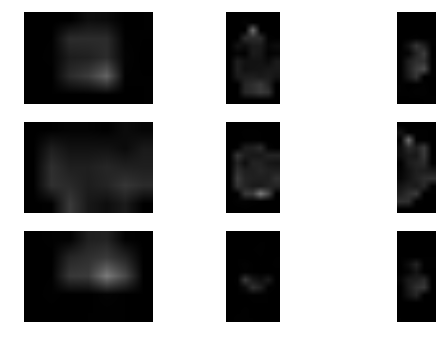

In [71]:
inImg_ds = imgResample(inImg, spacing=spacing)
imgShow(inImg_ds, vmax=500)

Notice how we used nearest-neighbor interpolation when downsampling the mask

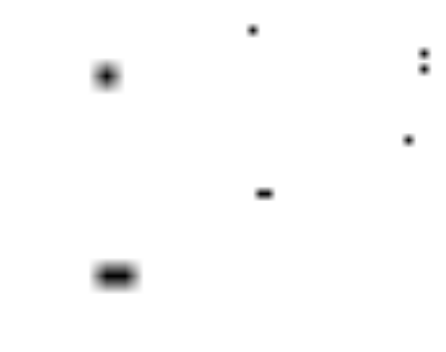

In [72]:
inMask_ds = imgResample(inMask, spacing=spacing, useNearest=True)
imgShow(inMask_ds)

Now we compute the affine transform.  Unlike in the [basic registration tutiorial](basicRegistration.ipynb) we'll use the *imgAffineComposite* instead of *imgAffine*.  *imgAffine* simply computes the affine transform between the input and reference images.  *imgAffineComposite* computes a translation then a rigid then an affine transformation.  It's output is the composition of those three transforms.  We use Mutual Information since the CLARITY and ARA images have very differnt intensity profiles.  We also enable the *verbose* option so that each iteration is printed.

In [73]:
affine = imgAffineComposite(inImg_ds, refImg_ds, inMask=inMask_ds, iterations=100, useMI=True, verbose=True)

Step translation:
0.	 -0.920146390175
1.	 -1.331491265
2.	 -1.33219617076
3.	 -1.371715415
4.	 -1.37829898333
5.	 -1.40530355255
6.	 -1.40992454273
7.	 -1.40764342885
8.	 -1.41545564122
9.	 -1.41761914801
10.	 -1.41292665996
11.	 -1.39524451863
12.	 -1.39835035222
13.	 -1.38873115418
14.	 -1.39853095571
15.	 -1.38887475894
16.	 -1.39148585678
17.	 -1.39099999993
18.	 -1.38833850134
19.	 -1.39017281883
20.	 -1.38890345648
21.	 -1.38663875469
22.	 -1.38791296777
23.	 -1.38846455079
24.	 -1.3879796294
Step rigid:
0.	 -1.11645735302
1.	 -1.51145645535
2.	 -1.45476238049
3.	 -1.38805845597
4.	 -1.4198465431
5.	 -1.51834396708
6.	 -1.5084980215
7.	 -1.51600188791
8.	 -1.51479757818
9.	 -1.5339002844
10.	 -1.53117297555
Step affine:
0.	 -1.28087753798
1.	 -1.40731523963
2.	 -1.25458455205
3.	 -1.28967186123
4.	 -1.42789508176
5.	 -1.4210784032
6.	 -1.43559334899
7.	 -1.49141483212
8.	 -1.4811625878
9.	 -1.47354365133
10.	 -1.48689004404
11.	 -1.48751465221
12.	 -1.49809400838


Now we apply the affine transform to the input CLARITY image and mask

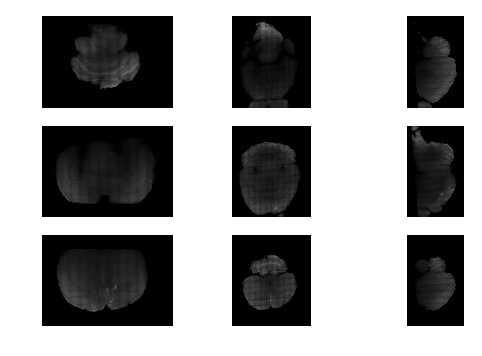

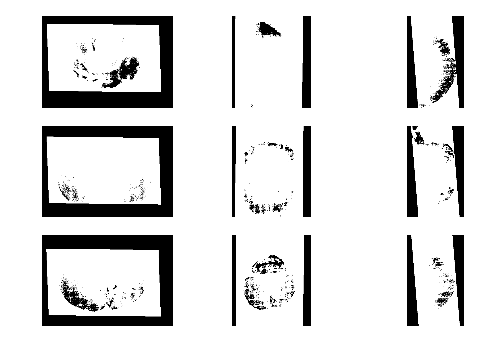

In [74]:
inImg_affine = imgApplyAffine(inImg, affine, size=refImg.GetSize())
imgShow(inImg_affine, vmax=500)

inMask_affine = imgApplyAffine(inMask, affine, size=refImg.GetSize(), useNearest=True)
imgShow(inMask_affine)

## LDDMM registration
Now we run LDDMM registration. Here we use *imgMetamorphosisComposite*.  Unlike *imgMetamorphosis* introduced in the [basic registration notebook](basicRegistration.ipynb), this function runs LDDMM in multiple steps using the alpha values specified by in *alphaList*. The *field* and *invField* outputs are the composition of all steps.  Once agan we use a Mutual Information cost because the input CLARITY brain and reference ARA average have very differnt intensity profiles.

In [75]:
inImg_ds = imgResample(inImg_affine, spacing=spacing)

In [76]:
inMask_ds = imgResample(inMask_affine, spacing=spacing, useNearest=True)

In [77]:
(field, invField) = imgMetamorphosisComposite(inImg_ds, refImg_ds, inMask=inMask_ds, alphaList=[0.05, 0.02, 0.01], useMI=True, iterations=100, verbose=True)


Step 0: alpha=0.05, beta=0.05, scale=1.0
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	-7.12562e+10, 19940.5, 0, -7.12562e+10 (95.9681%), 1.718750e-05
1.	-7.18528e+10, 20739.8, 0, -7.18528e+10 (94.9873%), 4.726563e-06
2.	-7.23501e+10, 22390.2, 0, -7.23501e+10 (94.1698%), 5.199219e-06
3.	-7.2913e+10, 22403.2, 0, -7.2913e+10 (93.2444%), 1.787231e-07
4.	-7.2999e+10, 22407.3, 0, -7.29991e+10 (93.103%), 4.914886e-08
5.	-7.3019e+10, 22408.1, 0, -7.3019e+10 (93.0702%), 1.351594e-08
E = -7.2216e+10 (94.3903%)
Length = 105.63
Time = 3.29371s (0.0548952m)

Step 1: alpha=0.02, beta=0.05, scale=1.0
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	-7.41487e+10, 843.724, 0, -7.41487e+10 (96.1389%), 2.148438e-06
1.	-7.46527e+10, 837.427, 0, -7.46527e+10 (95.2658%), 2.954102e-07
2.	-7.48594e+10, 838.131, 0, -7.48594e+10 (94.9076%), 8.123779e-08
3.	-7.48904e+10, 841.93, 0, -7.48904e+10 (94.8539%), 8.936157e-08
E = -7.48882e+10 (94.8577%)
Length = 37.7118
Time = 2.54403s (0.0

In [78]:
inImg_lddmm = imgApplyField(inImg_affine, field, size=refImg.GetSize())

In [79]:
inMask_lddmm = imgApplyField(inMask_affine, field, size=refImg.GetSize(), useNearest=True)

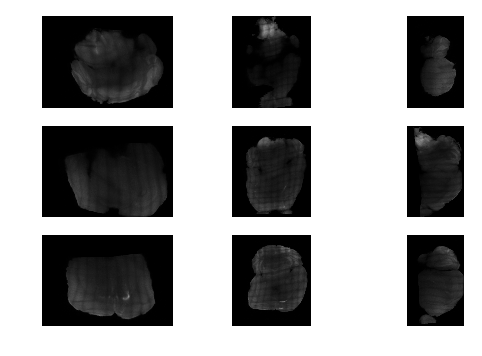

In [80]:
imgShow(inImg_lddmm, vmax = 500)

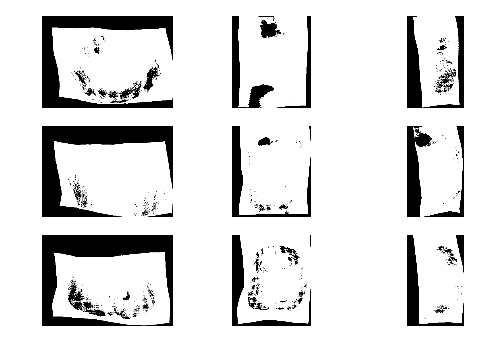

In [81]:
imgShow(inMask_lddmm)

We can now overlay tha ARA annotaions on the CLARITY image.

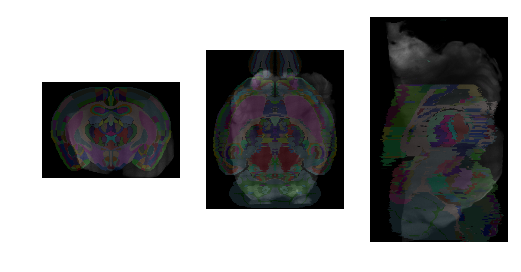

In [82]:
imgShow(inImg_lddmm, vmax=500, newFig=False, numSlices=1)
imgShow(refAnnoImg, vmax=1000, cmap=randCmap, alpha=0.2, newFig=False, numSlices=1)

## Evaluating the registration
We can evaluate the registration by generating a checkerboard of the deformed CLARITY and ARA.  In this method the input image is placed on the black squares of the metaphorical checkerboard while the reference image is placed on the red squares.  Idealy anatomical sturctures should line up across squares.

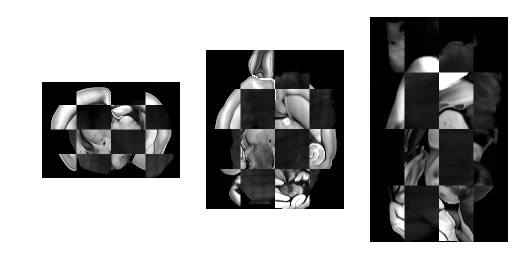

In [83]:
imgShow(imgChecker(inImg_lddmm, refImg, useHM=False), vmax=500, numSlices=1)

We can also evaluate the registration using the negative log Jacobian determinant of the displacement field.  Wherever it's negitive the input CLARITY image contracted during registration.  Wherever it's positive the CLARITY image expanded.

In [84]:
logJDet = -sitk.Log(sitk.DisplacementFieldJacobianDeterminant(field))

Since the field was computed on a downsampled grid we resample *logJDet* to the size of the deformed image.

In [85]:
logJDet = imgResample(logJDet, spacing=inImg_lddmm.GetSpacing(), size=inImg_lddmm.GetSize())

To overlay it on the deformed CLARITY image, we must set *newFig* to *False* so that matplotlib adds the *logJDet* data to the old figure instead of creating a new figure.

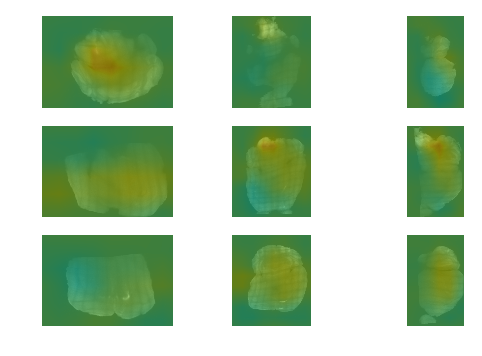

In [86]:
imgShow(inImg_lddmm, vmax=500, newFig=False)
imgShow(logJDet, newFig=False, alpha=0.5, cmap=plt.cm.jet, vmin=-2, vmax=2)
plt.show()

Let's add a colorbar so that it's clear what the color's mean. This is a little tricky so we'll do this one step at a time. First we get the current figure.

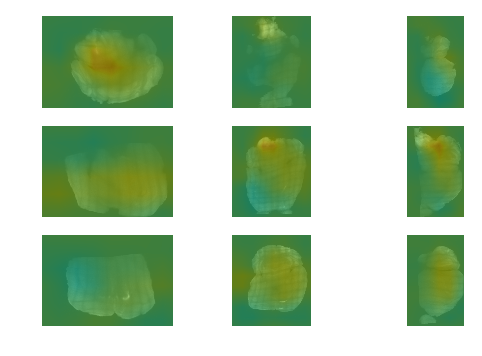

In [87]:
imgShow(inImg_lddmm, vmax=500, newFig=False)
imgShow(logJDet, newFig=False, alpha=0.5, cmap=plt.cm.jet, vmin=-2, vmax=2)
fig = plt.gcf()

There a 9 subplots in the figure.

In [88]:
fig.axes

Let's get the axis of the 0th subplot from the figure.

In [89]:
ax = fig.axes[0]

Each subplot has two images two images.  The 0th one is a slice from inImg_lddmm.  The 1st one is a slice from the logJDet.  Since we want the colorbar from logJDet we get the 1st image.

In [90]:
img_ax = ax.get_images()[1]

Now we make room for the colorbar, add an axis for it and the add it to the figure.

In [91]:
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.05, 0.6])
cbar = fig.colorbar(img_ax, cax=cbar_ax) 

Putting it all together.

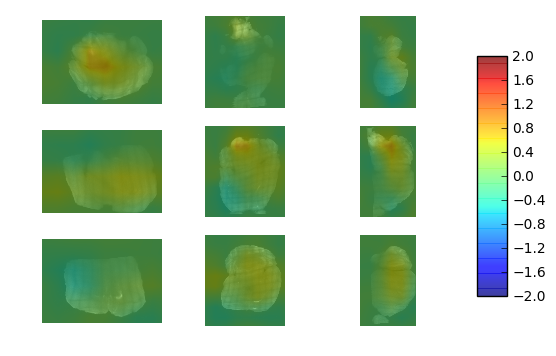

In [92]:
imgShow(inImg_lddmm, vmax=500, newFig=False)
imgShow(logJDet, newFig=False, alpha=0.5, cmap=plt.cm.jet, vmin=-2, vmax=2)
fig = plt.gcf()
ax = fig.axes[0]
img_ax = ax.get_images()[1]
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.05, 0.6])
cbar = fig.colorbar(img_ax, cax=cbar_ax) 
plt.show()

Since we see more reds, oranges and yellows than blues it's obious that the CLARITY brain expaned in most places during registration.